# Sensitivity analysis and baseline

In [1]:
# import
import numpy as np
import time, random, math, scipy, datetime, cv2
import matplotlib.pyplot as plt
import mediapy as media
import pandas as pd
from tqdm import tqdm
import matplotlib.gridspec as gridspec
from matplotlib.widgets import Slider
import ipywidgets as widgets
from IPython.display import display
from scipy.optimize import differential_evolution
from pathlib import Path
import sys, rootpath
root_dir = rootpath.detect()   # Get the root directory of the project (.git)
sys.path.insert(0, root_dir)  # insert at the beginning for higher priority (compatible with both version of python)
from utils.experiment import MujocoExperiment

In [2]:
# Tools
def smooth_data(data, window_size=5, axis=-1):
    """
    smooth the data
    Args:
        data: shape: (n_experiments, n_joints, n_timesteps)
        window_size: 
    Returns:
        smoothed_data: 
    """
    pad_width = window_size // 2
    # create the padded axis
    _dim = data.ndim
    _paddle_before_after = [(0,0) for _ in range(_dim)]
    _paddle_before_after[-1] = (pad_width, window_size-pad_width-1)     # the size = data_size + pad_size - window_size + 1
    padded_data = np.pad(data, _paddle_before_after, mode='edge')
    
    return np.apply_along_axis(
        lambda x: np.convolve(x, np.ones(window_size)/window_size, mode='valid'),
        axis=axis,
        arr=padded_data
    )

In [3]:
# Process the real data
# Original data: angles are in degrees, containing pressure1_start, pressure2_start, pressure1_end, pressure2_end, relative_time, thigh_theta21, calf_theta32
start_step_time = 5
pressure_group_num = 6
data_real_path = root_dir + "/src/physical_verify/dynamic/data/ToCenter_2025-02-20_21-06-20_A2B_data.csv"
data_real = pd.read_csv(data_real_path)
data_real["experiment_group"] = data_real.groupby(["pressure1_start", "pressure2_start", "pressure1_end", 
                                     "pressure2_end"]).ngroup()         # 0-35 Groups

expdata_real_lineInterp = []
expdata_real_splineInterp = []
expdata_real_origin = []     # original data
for group_id in data_real["experiment_group"].unique():
    # group_data_real is the data after the step starts
    group_data_real = data_real[data_real["experiment_group"]==group_id]
    group_data_real = group_data_real[group_data_real["relative_time"]>=start_step_time]

    # get the pressure setup of this group
    pressure1_start = group_data_real["pressure1_start"].iloc[0]    # visit data of this group
    pressure2_start = group_data_real["pressure2_start"].iloc[0]
    pressure1_end = group_data_real["pressure1_end"].iloc[0]
    pressure2_end = group_data_real["pressure2_end"].iloc[0]

    # get the data of this group
    time_real = np.array(group_data_real["relative_time"]-start_step_time)
    theta1_real = np.array(group_data_real["thigh_theta21"])
    theta2_real = np.array(group_data_real["calf_theta32"])

    # Interpolation, using linear interpolation and spline interpolation (k=3)
    t_intervel = np.linspace(0, 4, 401)
    delta_t = time_real[1] - time_real[0]

    theta1_real_lineInterp = np.interp(t_intervel, time_real, theta1_real)
    theta2_real_lineInterp = np.interp(t_intervel, time_real, theta2_real)
    theta1_spline = scipy.interpolate.make_interp_spline(time_real, theta1_real, k=3)
    theta2_spline = scipy.interpolate.make_interp_spline(time_real, theta2_real, k=3)
    theta1_real_splineInterp = theta1_spline(t_intervel)
    theta2_real_splineInterp = theta2_spline(t_intervel) 

    # stack all data and record in list
    expdata_real_lineInterp_one = np.stack((t_intervel, theta1_real_lineInterp, theta2_real_lineInterp), axis=0)
    expdata_real_splineInterp_one = np.stack((t_intervel, theta1_real_splineInterp, theta2_real_splineInterp), axis=0)
    expdata_real_origin_one = np.stack((time_real, theta1_real, theta2_real), axis=0)
    expdata_real_lineInterp.append(expdata_real_lineInterp_one)
    expdata_real_splineInterp.append(expdata_real_splineInterp_one)
    expdata_real_origin.append(expdata_real_origin_one)

# convert to numpy array
expdata_real_lineInterp = np.array(expdata_real_lineInterp)
expdata_real_splineInterp = np.array(expdata_real_splineInterp)
# expdata_real_origin = np.array(expdata_real_origin)       # for the length of each group is different, so we can't use np.array

print(f"expdata_real_lineInterp.shape: {expdata_real_lineInterp.shape}")
print(f"expdata_real_splineInterp.shape: {expdata_real_splineInterp.shape}")
print(f"expdata_real_origin.len: {len(expdata_real_origin)}")

# above data is all response of [init pressures], however, we need to select the effective data for the experiment.
data = pd.read_csv(root_dir + "/src/physical_verify/static/data/real_static_state/real(effective)_StaticPoint_6group.csv")
P1_array = data['P1 (kPa)'].values
P2_array = data['P2 (kPa)'].values
theta1_array = data['theta1 (deg)'].values
theta2_array = data['theta2 (deg)'].values

# theta1_array = np.array(theta1_array, dtype=np.float32)*np.pi/180 
# theta2_array = np.array(theta2_array, dtype=np.float32)*np.pi/180 
P1_array = np.array(P1_array, dtype=np.float32)*1000
P2_array = np.array(P2_array, dtype=np.float32)*1000

effective_idx = np.array((P1_array/10000) * pressure_group_num + (P2_array/10000), dtype=np.int16)
print("effective_idx: ", effective_idx)

# effective_idx = [19]  # TODO 30,10

expdata_real_lineInterp_effective = expdata_real_lineInterp[effective_idx]
expdata_real_splineInterp_effective = expdata_real_splineInterp[effective_idx]
expdata_real_origin_effective = [expdata_real_origin[i] for i in effective_idx]
# The shape of data is (13, 3, 401), namely (n_experiments, t-theta1-theta2, n_timesteps)
print(f"expdata_real_lineInterp_effective Shape = {expdata_real_lineInterp_effective.shape}")
print(f"expdata_real_splineInterp_effective Shape = {expdata_real_splineInterp_effective.shape}")
print(f"expdata_real_origin_effective Len = {len(expdata_real_origin_effective)}")


expdata_real_lineInterp.shape: (36, 3, 401)
expdata_real_splineInterp.shape: (36, 3, 401)
expdata_real_origin.len: 36
effective_idx:  [ 0  1  2  3  6  7  8 12 13 18 19 24 30]
expdata_real_lineInterp_effective Shape = (13, 3, 401)
expdata_real_splineInterp_effective Shape = (13, 3, 401)
expdata_real_origin_effective Len = 13


(13, 3, 401)


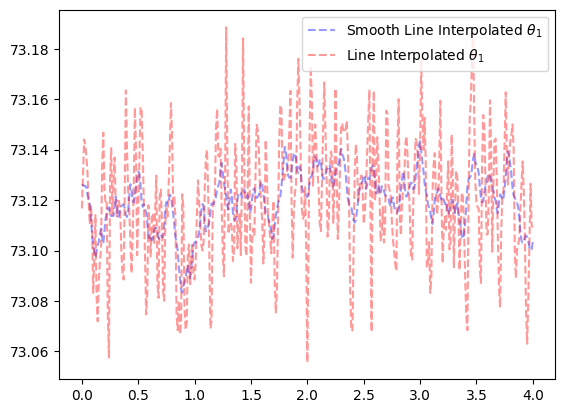

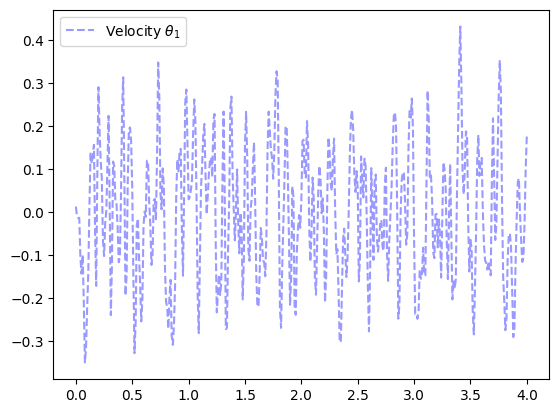

In [4]:
expdata_real_lineInterp_effective_smooth = smooth_data(expdata_real_lineInterp_effective, window_size=11, axis=-1)
velocity_real_lineInterp_effective_presmooth = np.gradient(expdata_real_lineInterp_effective_smooth, axis=-1)/delta_t

print(expdata_real_lineInterp_effective_smooth.shape)
plt.plot(expdata_real_lineInterp_effective[0, 0], expdata_real_lineInterp_effective_smooth[0, 1], color='blue', alpha=0.4, linestyle='--', label=r'Smooth Line Interpolated $\theta_1$')
plt.plot(expdata_real_lineInterp_effective[0, 0], expdata_real_lineInterp_effective[0, 1], color='red', alpha=0.4, linestyle='--', label=r'Line Interpolated $\theta_1$')
plt.legend()

plt.figure()
plt.plot(expdata_real_lineInterp_effective[0, 0], velocity_real_lineInterp_effective_presmooth[0, 1], color='blue', alpha=0.4, linestyle='--', label=r'Velocity $\theta_1$')
plt.legend()


In [5]:
# Sim Data Collection

path = (root_dir + "/models/v2_4/urdf/dog2_4singleLeg_realconstrast.xml")
experiment_instance = MujocoExperiment(path, xml_mode=True)

# a function wrapper to run the experiment and return the results
def run_single_experiment(params, ifrender=False, valveDynamics=False):
    """
    Run a single experiment with the given parameters.
    Args:
        params (dict): Dictionary of parameters to set for the experiment.
    Returns:
        time_sim (ndarray): Simulated time data.
        theta1_sim (ndarray): Simulated angle data for joint 1.
        theta2_sim (ndarray): Simulated angle data for joint 2.
        frames (list): List of frames generated during the simulation.
    """
    try:
        # Run the simulation
        time_step = 10
        duration_exp = 20
        time_sim, theta1_sim, theta2_sim, frames, _, _ = experiment_instance.run(params, time_step=time_step, duration=duration_exp, ifrender=ifrender)
        return time_sim, theta1_sim, theta2_sim, frames
    # ctrl C to quit
    except KeyboardInterrupt:
        pass

t_bias = 10         # TODO

# define the error function
def error(para, mode="train", t_bias=t_bias, return_type="error"):
    '''return the error/frames'''
    expdata_sim_all = []
    for p1, p2 in zip(P1_array[:], P2_array[:]):
      para["P1"] = p1
      para["P2"] = p2
      time_sim, theta1_sim, theta2_sim, frames = run_single_experiment(para, ifrender=False) 
         
      time_sim = time_sim - t_bias
      t_intervel = np.linspace(0, 4, 401)
      theta1_sim_intervel = np.interp(t_intervel, time_sim, theta1_sim) * 180 / np.pi
      theta2_sim_intervel = np.interp(t_intervel, time_sim, theta2_sim) * 180 / np.pi

      expdata_sim = np.stack((t_intervel, theta1_sim_intervel, theta2_sim_intervel), axis=0)  # 3*401
      expdata_sim_all.append(expdata_sim)
    expdata_sim_all = np.array(expdata_sim_all)   # 13*3*401

    # Error of theta1 and theta2
    q_errorMat = expdata_sim_all - expdata_real_lineInterp_effective_smooth
    q_SE_mat = q_errorMat**2
    q_MSE_mat = np.mean(q_SE_mat, axis=2)   # along the time axis
    q_MSE_mat_overview = np.mean(q_MSE_mat, axis=0) # along the group axis
    q_MSE_sum = np.mean(q_MSE_mat_overview[1:]) # along the joint axis(MSE of theta1 plus MSE of theta2)
    q_RMSE = np.sqrt(q_MSE_sum)

    # Error of angular velocity(vs velocity_real_lineInterp_effective_presmooth)
    qd_sim = np.gradient(expdata_sim_all, axis=-1)/delta_t
    qd_errorMat = qd_sim - velocity_real_lineInterp_effective_presmooth
    qd_SE_mat = qd_errorMat**2
    qd_MSE_mat = np.mean(qd_SE_mat, axis=2)
    qd_MSE_mat_overview = np.mean(qd_MSE_mat, axis=0)
    qd_MSE_sum = np.mean(qd_MSE_mat_overview[1:])   # along the joint axis(MSE of theta1 plus MSE of theta2)
    # print(f"q_MSE_sum: {q_MSE_sum:.4f}, qd_MSE_sum: {qd_MSE_sum:.4f}")
    velocity_sim_sign = np.where(qd_sim > 0, 1, -1)
    velocity_real_sign = np.where(velocity_real_lineInterp_effective_presmooth > 0, 1, -1)
    errorMat_velocity = np.where(velocity_sim_sign == velocity_real_sign, 0, 1)
    errorMat_velocity_sum = np.mean(errorMat_velocity, axis=0)  # along the group axis
    errorMat_velocity_sum = np.mean(errorMat_velocity_sum[1:])  # along the joint axis
    errorMat_velocity_sum_mean = np.mean(errorMat_velocity_sum)

    # print(f"[RMSE]: {np.sqrt(q_MSE_sum):.8f}")
    if return_type == "frames":
        return q_RMSE, expdata_sim_all
    elif return_type == "error":
        return q_RMSE + 0*q_MSE_sum + 0*100*errorMat_velocity_sum_mean


k1_opt = 265.8241475038647
k2_opt = 110.35587085946752
l10_opt = 0.18030933265375373
l20_opt = 0.2565263437073504
c1_opt = 12.481528852527212
c2_opt = 24.786338846294175
s1_opt = 0.000402878523871013
s2_opt = 0.0004359278762327848
c1_thigh_opt = 0.5235405629870382
c2_calf_opt = 0.06173716079499769

# mass set
RB_MAA_uGeom = 0.03108
RB_MAA_mGeom = 0.12432
RB_MAA_lGeom = 0.03108

RB_BAA_uGeom = 0.04544333333
RB_BAA_mGeom = 0.1817733333
RB_BAA_lGeom = 0.04544333333

para = {
  'stiffness_MAA': k1_opt,
  'stiffness_BAA': k2_opt,
  'l10': l10_opt,
  'l20': l20_opt,
  'damping_MAA': c1_opt,
  'damping_BAA': c2_opt,
  's1': s1_opt,
  's2': s2_opt,
  'c1_thigh': c1_thigh_opt,
  'c2_calf': c2_calf_opt,
  'P1': 0,        # to set from the experimental data
  'P2': 0,
  'P1_prime': 0.0,
  'P2_prime': 0.0,
  'RB_MAA_uGeom': RB_MAA_uGeom,
  'RB_MAA_mGeom': RB_MAA_mGeom,
  'RB_MAA_lGeom': RB_MAA_lGeom,
  'RB_BAA_uGeom': RB_BAA_uGeom,
  'RB_BAA_mGeom': RB_BAA_mGeom,
  'RB_BAA_lGeom': RB_BAA_lGeom,
}

# a demo
# k1, k2, l10, l20, c1, c2, s1, s2, c1_thigh, c2_calf = params
print(error(para))

1.8633574817808098


In [ ]:

def sensitivity_analysis(base_para, keys_to_analyze, delta_ratio=0.05):
    base_error = error(base_para)
    results = []

    for key in keys_to_analyze:
        if key not in base_para:
            continue
        
        original_value = base_para[key]
        if original_value == 0:
            continue 

        delta = original_value * delta_ratio

        para_plus = base_para.copy()
        para_plus[key] += delta
        error_plus = error(para_plus)
        sens_plus = (error_plus - base_error) / delta
        rel_sens_plus = (error_plus - base_error) / base_error / delta_ratio

        results.append({
            'parameter': key,
            'base_value': original_value,
            'delta_ratio': delta_ratio,
            'error_base': base_error,
            'error_plus': error_plus,
            'sensitivity_plus': sens_plus,
            'relative_sensitivity_plus': rel_sens_plus,
        })

    return results

keys = ['RB_MAA_uGeom', 'RB_MAA_mGeom', 'RB_MAA_lGeom', 'RB_BAA_uGeom', 'RB_BAA_mGeom', 'RB_BAA_lGeom',
        'stiffness_MAA', 'stiffness_BAA', 'l10', 'l20', 'damping_MAA', 'damping_BAA', 's1', 's2']
delta_ratios = [-0.1, -0.05, -0.01, 0.01, 0.05, 0.1]
result_log = []
for idx in tqdm(range(len(delta_ratios))):
    df_sens = sensitivity_analysis(para, keys, delta_ratio=delta_ratios[idx])
    result_log += df_sens

result_log_df = pd.DataFrame(result_log)
result_log_df

100%|██████████| 6/6 [01:38<00:00, 16.48s/it]


,parameter,base_value,delta_ratio,error_base,error_plus,sensitivity_plus,relative_sensitivity_plus
0,RB_MAA_uGeom,0.031080,-0.1,1.863357,1.863357,-1.139749e-06,-1.901053e-08
1,RB_MAA_mGeom,0.124320,-0.1,1.863357,1.846279,1.373768e+00,9.165544e-02
2,RB_MAA_lGeom,0.031080,-0.1,1.863357,1.853839,3.062475e+00,5.108076e-02
3,RB_BAA_uGeom,0.045443,-0.1,1.863357,1.863357,-5.990591e-07,-1.460978e-08
4,RB_BAA_mGeom,0.181773,-0.1,1.863357,1.876746,-7.365255e-01,-7.184918e-02
...,...,...,...,...,...,...,...
79,l20,0.256526,0.1,1.863357,9.796797,3.092641e+02,4.257605e+01
80,damping_MAA,12.481529,0.1,1.863357,1.861771,-1.271416e-03,-8.516462e-03
81,damping_BAA,24.786339,0.1,1.863357,1.852832,-4.246459e-03,-5.648630e-02
82,s1,0.000403,0.1,1.863357,1.803218,-1.492752e+03,-3.227495e-01


In [7]:
result_log_df.to_csv("./log/sensitivity_analysis.csv", index=False)

7


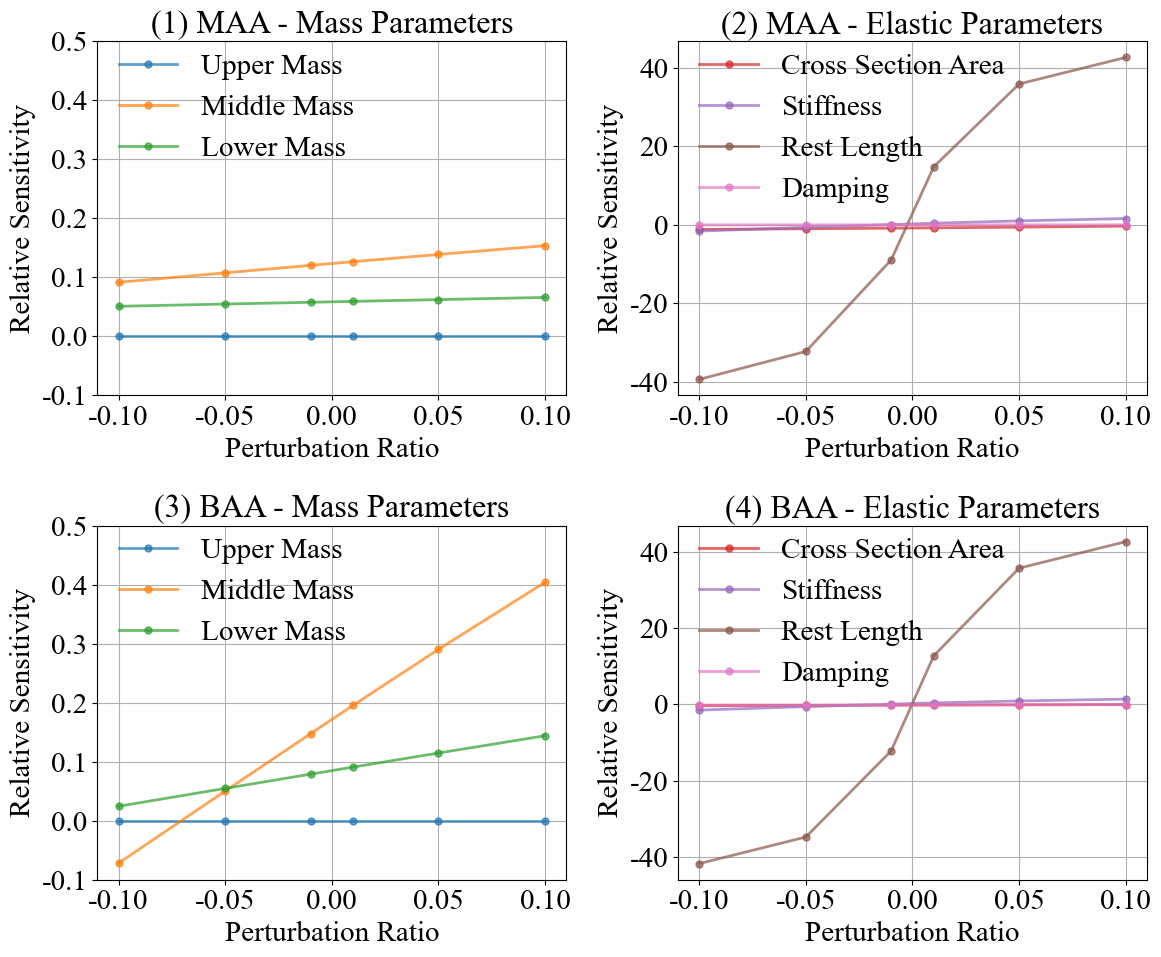

In [8]:
# analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rcParams

config = {
    "font.family":'Times New Roman',  
    "axes.unicode_minus": False,
    "font.size": 21,
}
rcParams.update(config)

df = result_log_df

alias_map = {
    'RB_MAA_uGeom': 'MAA Upper Mass',
    'RB_MAA_mGeom': 'MAA Middle Mass',
    'RB_MAA_lGeom': 'MAA Lower Mass',
    's1': 'MAA Cross Section Area',
    'stiffness_MAA': 'MAA Stiffness',
    'l10': 'MAA Rest Length',
    'damping_MAA': 'MAA Damping',

    'RB_BAA_uGeom': 'BAA Upper Mass',
    'RB_BAA_mGeom': 'BAA Middle Mass',
    'RB_BAA_lGeom': 'BAA Lower Mass',
    's2': 'BAA Cross Section Area',
    'stiffness_BAA': 'BAA Stiffness',
    'l20': 'BAA Rest Length',
    'damping_BAA': 'BAA Damping',
}

ordered_params = list(alias_map.keys())

params = df["parameter"].unique()
print(len(params)//2)
palette = sns.color_palette("tab10", len(params)//2)
color_map = {param: palette[i%len(palette)] for i, param in enumerate(ordered_params)}

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

plot_group = {
    0: ['RB_MAA_uGeom', 'RB_MAA_mGeom', 'RB_MAA_lGeom'],
    1: ['s1', 'stiffness_MAA', 'l10', 'damping_MAA'],
    2: ['RB_BAA_uGeom', 'RB_BAA_mGeom', 'RB_BAA_lGeom'], 
    3: ['s2', 'stiffness_BAA', 'l20', 'damping_BAA']
}

for i, ax in enumerate(axes):
    for param in plot_group[i]:
    
        label = alias_map[param][4:]

        ax.plot(df[df['parameter'] == param]['delta_ratio'], 
                df[df['parameter'] == param]['relative_sensitivity_plus'], 
                marker='o', linestyle='-', color=color_map[param], label=label, alpha=0.7, linewidth=2, markersize=5)

    ax.set_xlabel('Perturbation Ratio')
    ax.set_ylabel('Relative Sensitivity')
    if i%2==0:
        ax.set_ylim(-0.1, 0.5)
    name = {
        1: 'MAA - Mass Parameters',
        2: 'MAA - Elastic Parameters',
        3: 'BAA - Mass Parameters',
        4: 'BAA - Elastic Parameters'
    }
    ax.set_title(f"({i+1}) {name[i+1]}", fontsize=23)

    handles, labels = ax.get_legend_handles_labels()
    unique = dict(zip(labels, handles))
    ax.legend(unique.values(), unique.keys(), loc="upper left", bbox_to_anchor=(-0.01, 1.04), fontsize=21, frameon=False)

    ax.grid(True)

# plt.suptitle('Sensitivity Analysis of Parameters', fontsize=26)
plt.tight_layout()
# save
plt.savefig('./figure/sensitivity_analysis.png', dpi=300)
plt.show()


In [9]:

# get all sim trajectory data
def evaluate_baseline(para):
    round_name = ['EquiMus', 'PureMuJoCo']
    exp_log = []
    for i, name in enumerate(round_name):
        para_run = para.copy()
        expdata_sim_all = []
        MAA_mass = para['RB_MAA_uGeom'] + para['RB_MAA_mGeom'] + para['RB_MAA_lGeom']
        BAA_mass = para['RB_BAA_uGeom'] + para['RB_BAA_mGeom'] + para['RB_BAA_lGeom']
        for p1, p2 in zip(P1_array, P2_array):
            para_run['P1'] = p1
            para_run['P2'] = p2

            # TODO: Baseline
            config_num = 1/6
            MIN_MASS = 1e-6
            if name == 'EquiMus':
                para_run['RB_MAA_uGeom'] = MAA_mass * config_num
                para_run['RB_MAA_mGeom'] = MAA_mass * (1-2*config_num)
                para_run['RB_MAA_lGeom'] = MAA_mass * config_num

                para_run['RB_BAA_uGeom'] = BAA_mass * config_num
                para_run['RB_BAA_mGeom'] = BAA_mass * (1-2*config_num)
                para_run['RB_BAA_lGeom'] = BAA_mass * config_num
            else:
                para_run['RB_MAA_uGeom'] = MIN_MASS
                para_run['RB_MAA_mGeom'] = MIN_MASS
                para_run['RB_MAA_lGeom'] = MIN_MASS

                para_run['RB_BAA_uGeom'] = MIN_MASS
                para_run['RB_BAA_mGeom'] = MIN_MASS
                para_run['RB_BAA_lGeom'] = MIN_MASS

            time_sim, theta1_sim, theta2_sim, _frames = run_single_experiment(para, ifrender=False)
            t_bias = 10
            time_sim = time_sim - t_bias
            t_intervel = np.linspace(0, 4, 401)
            theta1_sim_intervel = np.interp(t_intervel, time_sim, theta1_sim)
            theta2_sim_intervel = np.interp(t_intervel, time_sim, theta2_sim)
            expdata_sim = np.stack((t_intervel, theta1_sim_intervel, theta2_sim_intervel), axis=0) 
            expdata_sim_all.append(expdata_sim)
        expdata_sim_all = np.array(expdata_sim_all)
        traj_error = error(para=para_run)
        exp_log.append({
            'name': name,
            # 'expdata_sim_all': expdata_sim_all,
            'error': traj_error*np.pi/180
        })
    return exp_log

# cal the error
exp_log = evaluate_baseline(para=para)
exp_log = pd.DataFrame(exp_log)
exp_log.to_csv("./log/baseline_analysis.csv", index=False)
print(exp_log)


         name     error
0     EquiMus  0.032522
1  PureMuJoCo  0.432144
